In [ ]:
#imports
import matplotlib.pyplot as plt
import cv2
import numpy as np

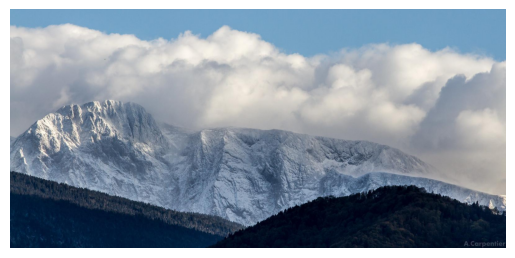

In [18]:
#reading and showing image
img_path = "img/landscape.jpg"

image = plt.imread(img_path)

plt.imshow(image)
plt.axis('off')
plt.show()

In [36]:
#self.image -> cv2.imread(img_path) where img_path = "img/landscape.png"
class bitPlaneSlicing: 
    def __init__(self, image: np.ndarray):
        self.image = image

    def greyScale(self) -> np.ndarray:
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.imshow("Grey image: ", gray_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        return gray_img

In [39]:
#redefine image with cv2 lib
img_path = "img\\landscape.png"
image = cv2.imread(img_path)

bitPlane = bitPlaneSlicing(image)

gray_img = bitPlane.greyScale()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
